In [1]:
from hdbcli import dbapi
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns


from functools import reduce

from datetime import datetime
import datetime

pd.set_option('display.max_columns', None)

load_dotenv()

False

In [2]:
serverAdress_prod='vp55db01.sce.com' 
serverPort_prod=30015 
userName_prod = 'XXXX'
passWord_prod = 'xxxxxxxx'
#userName_prod=os.getenv('USER') 
#passWord_prod=os.getenv('PASSWORD') 

# Connect to hana database
try:
    cnn = dbapi.connect(serverAdress_prod,serverPort_prod,userName_prod,passWord_prod) 
    print('SAP connection established')
    cursor_prod=cnn.cursor() 
except Exception as e:
    print(f'ERROR: {e}')

SAP connection established


In [3]:
import vertexai
from snowflake.snowpark import Session
from snowflake.connector.pandas_tools import write_pandas

from google.cloud import secretmanager
from google.cloud import aiplatform
from google.cloud import storage
import json
import time

def access_secret_version(project_id, secret_id, version_id="latest"):
    client = secretmanager.SecretManagerServiceClient()
    name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"

    response = client.access_secret_version(request={"name": name})
    payload = response.payload.data.decode("UTF-8")
    return payload

/opt/conda/lib/python3.10/site-packages/snowflake/connector/options.py:104: UserWarning: You have an incompatible version of 'pyarrow' installed (20.0.0), please install a version that adheres to: 'pyarrow<19.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [4]:
path_name='gs://ebill_enrollment_model/input_20250811'
cutoff_date='2025-08-11'

## Part 1 - E-Bill enrollment

#### 1.1 - all active residential customers as of the cutoff date
* Move Out date >= cutoff date
* Move In date < cutoff date

In [5]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

     SELECT DISTINCT MD."0CACONT_ACC" AS cact,
       MD."0BBP_BUYID" as bp,
       MD."ZPLITEAL" as rate_plan,
       MD."0UCRATE_CAT" as rate_plan_cat,
       case when "ZHAUSNUM" is null or "4ZMD_A008_HOUSE_NUM2" is null then 0 else 1 end as unit_num, 
       case when "ZLANDLINE" is null then 0 else 1 end as landline, 
       case when "ZMOBILENU" is null then 0 else 1 end as mobilephone,
       case when "ZTELNUM" is null then 0 else 1 end as having_phone, 
       "CC_CUSTOMER_TYPE_D" as cust_type, 
       "CC_CRITICAL_CARE_FLAG" as critical_care, 
      MD."0UCCONTRACT" as cactnum,
      to_date(MD."0UCMOVEIN_D") as movein_date,
      to_date(MD."0UCMOVEOUTD") as moveout_date,
      MD."ZSCTRL_GP" as bill_type, 
      case when MD."0EMAIL_ADDR" like '%@%' then 1 else 0 end as have_email
      FROM _SYS_BIC."sce.cs.md.core/CV_UTILITIES_MASTER" as MD
      WHERE MD."0UCACC_CLAS"='RESI' 
      and to_date(MD."0UCMOVEOUTD") >= cutoff_date 
      and to_date(MD."0UCMOVEIN_D") < cutoff_date;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [6]:
all_resi_model=pd.DataFrame(ret)
all_resi_model.columns=['cact', 'bp', 'rate_plan', 'rate_plan_cat', 'unit_num', 'landline',
                        'mobilephone', 'having_phone', 'cust_type', 'critical_care', 
                        'cactnum', 'movein_date', 'moveoutdate', 'bill_type', 'have_email'] 
all_resi_model.info()
all_resi_model.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4685111 entries, 0 to 4685110
Data columns (total 15 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cact           object
 1   bp             object
 2   rate_plan      object
 3   rate_plan_cat  object
 4   unit_num       int64 
 5   landline       int64 
 6   mobilephone    int64 
 7   having_phone   int64 
 8   cust_type      object
 9   critical_care  object
 10  cactnum        object
 11  movein_date    object
 12  moveoutdate    object
 13  bill_type      object
 14  have_email     int64 
dtypes: int64(5), object(10)
memory usage: 536.2+ MB


,cact,bp,rate_plan,rate_plan_cat,unit_num,landline,mobilephone,having_phone,cust_type,critical_care,cactnum,movein_date,moveoutdate,bill_type,have_email
0,700363064778,1001065924,D-CARE,D,1,1,1,1,Domestic,No,8000053866,2021-03-08,9999-12-31,EBIL,1
1,700984428590,1008725721,TOUD-4-9PM,TD49,1,1,1,1,Domestic,None,8020368295,2025-06-06,9999-12-31,,1
2,700984428590,1008725721,DOMESTIC,D,1,1,1,1,Domestic,None,8020368295,2025-06-06,9999-12-31,,1
3,700227225776,1004484990,DOMESTIC,D,1,1,1,1,Domestic,None,8003201093,2021-03-20,9999-12-31,HCB,0
4,700582573253,1004526277,TOUD-4-9PM-CARE,TD49,1,1,1,1,Domestic,No,8000862346,2021-03-03,9999-12-31,EBIL,1


In [7]:
all_resi_model['have_email'].mean()

np.float64(0.8315177591310003)

In [8]:
all_resi_model.to_csv(str(path_name)+str('/all_resi_model.csv'), index=False)

#### 1. 2 - all customers with email as of cutoff date
* Emails from MyAccount and contact table will be pulled.

In [9]:
# email from CV_CONSENT_GUID_WEBID (for MyAccount)
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

     select ZMOBJKEY as cact,
     "0BPARTNER" as bp,
     "0VALIDFROM___T" as email_valid_from,
     "0VALIDTO___T" as email_valid_to,
      EMAIL
     from "_SYS_BIC"."sce.cs.id.core/CV_CONSENT_GUID_WEBID"
     where to_date("0VALIDTO___T") >= cutoff_date
       and to_date("0VALIDFROM___T") < cutoff_date
      and email like '%@%';
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [10]:
email_myacct=pd.DataFrame(ret)
email_myacct.columns=['cact', 'bp', 'email_valid_from', 'email_valid_to', 'email'] 
email_myacct.info()
email_myacct.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6341299 entries, 0 to 6341298
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   cact              object
 1   bp                object
 2   email_valid_from  object
 3   email_valid_to    object
 4   email             object
dtypes: object(5)
memory usage: 241.9+ MB


,cact,bp,email_valid_from,email_valid_to,email
0,700603364595,1000880884,2024-09-14,9999-12-31,sagarpankajparekh@gmail.com
1,700898474870,1008144336,2024-09-16,9999-12-31,gianna@epochprojects.com
2,700508959549,1003636042,2024-09-14,9999-12-31,susanbauer04@gmail.com
3,700921229454,1008308318,2024-09-16,9999-12-31,jetta3john@yahoo.com
4,700530058665,1005633834,2021-04-03,9999-12-31,stevecapilouto@gmail.com


In [11]:
email_myacct.to_csv(str(path_name)+str('/email_myacct.csv'), index=False)

In [12]:
# email from SV_BP_CONTACT_DETAILS
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

     SELECT
          Table__1."0BPARTNER" AS BP, 
          Table__1."ZCOMM_VALIDFRM", 
          Table__1."ZCOMM_VALIDTO",  
          Table__1."ZSMTP_AD" AS BP_EMAIL, 
          Table__1."ZEMAIL_DEFAULT_FROM", 
          Table__1."ZEMAIL_DEFAULT_TO" 
     FROM "_SYS_BIC"."sce.cs.cim.sem/SV_BP_CONTACT_DETAILS"  Table__1
     WHERE Table__1."ZSTATUSC" IN ('EMAIL')
       AND Table__1."ZSMTP_AD" IS NOT NULL
       AND to_date(Table__1."ZCOMM_VALIDTO") >= cutoff_date 
       and to_date(Table__1."ZCOMM_VALIDFRM") < cutoff_date 
       AND Table__1."ZCOMM_VALIDFRM" IS NOT NULL
       AND Table__1."ZSMTP_AD" like '%@%';
     end;
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [13]:
email_contact=pd.DataFrame(ret)
email_contact.columns=['bp', 'ZCOMM_VALIDFRM', 'ZCOMM_VALIDTO', 'bp_email', 'email_contact_from',
                       'email_contact_to']
email_contact.info()
email_contact.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10535471 entries, 0 to 10535470
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   bp                  object
 1   ZCOMM_VALIDFRM      object
 2   ZCOMM_VALIDTO       object
 3   bp_email            object
 4   email_contact_from  object
 5   email_contact_to    object
dtypes: object(6)
memory usage: 482.3+ MB


,bp,ZCOMM_VALIDFRM,ZCOMM_VALIDTO,bp_email,email_contact_from,email_contact_to
0,1000076764,2024-09-02,9999-12-31,NATEDOGT@GMAIL.COM,2024-09-02,9999-12-31
1,1007420560,2023-04-26,9999-12-31,worshipintruth@att.net,2023-04-26,9999-12-31
2,1000232932,2022-12-09,9999-12-31,LADONNADEBARROS@GMAIL.COM,2022-12-09,9999-12-31
3,1004140395,2021-11-05,9999-12-31,brianhuang31@gmail.com,2021-11-05,9999-12-31
4,1005572342,2024-09-02,9999-12-31,guoguominghui@yahoo.com,2024-09-02,9999-12-31


In [14]:
email_contact.to_csv(str(path_name)+str('/email_contact.csv'), index=False)

#### 1.3 - Customers who have enrolled or opted out in the past (by cutoff date)

In [9]:
# notice we use 2025-02-01 as the cutoff data for enrollment
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

    SELECT 
            ZOBJTID as cact,
            max(to_date(ZUDATE___T))    as last_enroll_date,
            min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_enroll_recency, 
            count(ZVALUEOLD) as enroll_cnt_total,
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as enroll_cnt_lastyear,
            sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as enroll_cnt_last2years 
        FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUENEW = 'EBIL'
            and to_date(ZUDATE___T) < cutoff_date
        group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [10]:
past_enroll=pd.DataFrame(ret)
past_enroll.columns=['cact', 'past_enroll_date', 'past_enroll_recency', 'enroll_cnt_total', 'enroll_cnt_lastyear', 'enroll_cnt_last2years']
past_enroll.info()
past_enroll.head()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105204 entries, 0 to 3105203
Data columns (total 6 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   cact                   object
 1   past_enroll_date       object
 2   past_enroll_recency    int64 
 3   enroll_cnt_total       int64 
 4   enroll_cnt_lastyear    int64 
 5   enroll_cnt_last2years  int64 
dtypes: int64(4), object(2)
memory usage: 142.1+ MB


,cact,past_enroll_date,past_enroll_recency,enroll_cnt_total,enroll_cnt_lastyear,enroll_cnt_last2years
0,700433011478,2024-07-23,384,2,0,2
1,700665493196,2023-02-25,898,1,0,0
2,700661580359,2021-06-11,1522,1,0,0
3,700873725322,2024-04-30,468,1,0,1
4,700783362849,2023-01-30,924,1,0,0


In [11]:
past_enroll.to_csv(str(path_name)+str('/past_enroll.csv'), index=False)

In [5]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

    SELECT ZOBJTID as cact,
                   max(to_date(ZUDATE___T)) as latest_optout_date, 
                   min(days_between(to_date(ZUDATE___T), cutoff_date)) as last_optout_recency, 
                   count(ZVALUEOLD) as opt_out_count_total,
                   sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 365 then 1 else 0 end) as optout_cnt_lastyear,
                   sum(case when days_between(to_date(ZUDATE___T), cutoff_date) < 730 then 1 else 0 end) as optout_cnt_last2years 
            FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"
            WHERE ZVALUEOLD = 'EBIL'
              and to_date(ZUDATE___T) < cutoff_date
       group by ZOBJTID;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [6]:
past_optout=pd.DataFrame(ret)
past_optout.columns=['cact', 'latest_optout_date', 'last_optout_recency', 'opt_out_cnt_total', 'optout_cnt_lastyear', 'optout_cnt_last2years']
past_optout.info()
past_optout.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878991 entries, 0 to 878990
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   878991 non-null  object
 1   latest_optout_date     878991 non-null  object
 2   last_optout_recency    878991 non-null  int64 
 3   opt_out_cnt_total      878991 non-null  int64 
 4   optout_cnt_lastyear    878991 non-null  int64 
 5   optout_cnt_last2years  878991 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 40.2+ MB


,cact,latest_optout_date,last_optout_recency,opt_out_cnt_total,optout_cnt_lastyear,optout_cnt_last2years
0,700827953143,2023-09-21,690,1,0,1
1,700661692315,2023-06-24,779,1,0,0
2,700808980953,2025-04-12,121,1,1,1
3,700888235916,2025-07-04,38,8,8,8
4,700592633466,2025-02-26,166,2,1,1


In [7]:
print(past_optout['latest_optout_date'].min())
print(past_optout['latest_optout_date'].max())

2021-04-06
2025-08-10


In [8]:
past_optout.to_csv(str(path_name)+str('/past_optout.csv'), index=False)

#### 1.4 - GOV, SR. Citizen, Bankruptcy, Disaster Relief & Redlist

In [22]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

SELECT DISTINCT  
          t1.*
      FROM _SYS_BIC."system-local.bw.bw2hana/ZMD_A040" t1
      WHERE "0BP_ID_TYPE" IN ('ZFED','ZOTH','ZSTA','ZCIT','ZCOU', 'ZBAN', 'ZSRC', 'ZDIS', 'ZCAS') 
      AND to_date("0DATETO___T") >= cutoff_date
      AND to_date("0DATEFROM___T") <= cutoff_date;
end; 
'''

In [23]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [24]:
excl_exempt=pd.DataFrame(ret)
excl_exempt.columns=['0BP_ID_DATE',
'0BP_ID_NUM',
'0BP_ID_TYPE',
'0BP_ID_TYPE___T',
'0COUNTRY',
'0COUNTRY___T',
'0DATEFROM',
'0DATETO',
'0FLGDELETED',
'0REGION',
'0REGION___T',
'0REQTSN',
'0TIME',
'0UPD_DATE',
'ZBP_PART',
'ZBP_PART___T',
'ZINSTITUT',
'0BP_ID_DATE___T',
'0DATEFROM___T',
'0DATETO___T',
'0TIME___T',
'0UPD_DATE___T',
'__AP_CHECK_INT',
'1ROWCOUNT']
excl_exempt.info()
excl_exempt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408196 entries, 0 to 408195
Data columns (total 24 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   0BP_ID_DATE      408196 non-null  object
 1   0BP_ID_NUM       408196 non-null  object
 2   0BP_ID_TYPE      408196 non-null  object
 3   0BP_ID_TYPE___T  408196 non-null  object
 4   0COUNTRY         408196 non-null  object
 5   0COUNTRY___T     142172 non-null  object
 6   0DATEFROM        408196 non-null  object
 7   0DATETO          408196 non-null  object
 8   0FLGDELETED      408196 non-null  object
 9   0REGION          408196 non-null  object
 10  0REGION___T      2244 non-null    object
 11  0REQTSN          408196 non-null  object
 12  0TIME            408196 non-null  object
 13  0UPD_DATE        408196 non-null  object
 14  ZBP_PART         408196 non-null  object
 15  ZBP_PART___T     408196 non-null  object
 16  ZINSTITUT        408196 non-null  object
 17  0BP_ID_DAT

,0BP_ID_DATE,0BP_ID_NUM,0BP_ID_TYPE,0BP_ID_TYPE___T,0COUNTRY,0COUNTRY___T,0DATEFROM,0DATETO,0FLGDELETED,0REGION,0REGION___T,0REQTSN,0TIME,0UPD_DATE,ZBP_PART,ZBP_PART___T,ZINSTITUT,0BP_ID_DATE___T,0DATEFROM___T,0DATETO___T,0TIME___T,0UPD_DATE___T,__AP_CHECK_INT,1ROWCOUNT
0,00000000,X,ZSRC,Sr Citizen Occupant,US,USA,20191101,99991231,,,None,00000000000000000000000,205927,20250820,1004446979,CATHERINE BERGMANN,,None,2019-11-01,9999-12-31,20:59:27,2025-08-20,1,1
1,00000000,001,ZCAS,Cash ONLY,,None,20250409,20251006,,,None,00000000000000000000000,205938,20250820,1008529964,Daniel Romero,,None,2025-04-09,2025-10-06,20:59:38,2025-08-20,1,1
2,00000000,JANUARY 2025 WIND AND FIRE STORMS,ZDIS,Disaster Relief,,None,20250107,20260108,,,None,00000000000000000000000,205944,20250820,1004251207,JANET CHUNG,,None,2025-01-07,2026-01-08,20:59:44,2025-08-20,1,1
3,00000000,X,ZSRC,Sr Citizen Occupant,,None,00010101,99991231,,,None,00000000000000000000000,205944,20250820,1007096929,YEN NGUYEN HOANG,,None,0001-01-01,9999-12-31,20:59:44,2025-08-20,1,1
4,00000000,X,ZSRC,Sr Citizen Occupant,US,USA,20190213,99991231,,,None,00000000000000000000000,205927,20250820,1002788143,JOANNE PERKINS,,None,2019-02-13,9999-12-31,20:59:27,2025-08-20,1,1


In [25]:
excl_exempt.to_csv(str(path_name)+str('/excl_exempt.csv'), index=False)

#### 1.5 - DE rate

In [26]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

SELECT DISTINCT 
          t1."0UCINSTALLA" AS INSTALLATION,
          t1."0UCOPERAND" AS EMPL,
          t1."0DATEFROM___T" AS EMPL_DATEFROM, 
          t1."0DATETO___T" AS EMPL_DATETO

      FROM _SYS_BIC."system-local.bw.bw2hana/ZUB_A006" t1 
        WHERE t1."0UCOPERAND" IN ('EFL-EMPL','GFL-EMPL')
        AND to_date(t1."0DATETO___T") >= current_date;
end; 
'''

In [27]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [28]:
de=pd.DataFrame(ret)
de.columns=['INSTALLATION', 'EMPL', 'MPL_DATEFROM', 'EMPL_DATETO']
de.info()
de.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14430 entries, 0 to 14429
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   INSTALLATION  14430 non-null  object
 1   EMPL          14430 non-null  object
 2   MPL_DATEFROM  14430 non-null  object
 3   EMPL_DATETO   14430 non-null  object
dtypes: object(4)
memory usage: 451.1+ KB


,INSTALLATION,EMPL,MPL_DATEFROM,EMPL_DATETO
0,0905501812,EFL-EMPL,2024-06-18,9999-12-31
1,0901405625,EFL-EMPL,2018-03-13,9999-12-31
2,0901399774,EFL-EMPL,2001-03-30,9999-12-31
3,0903418958,EFL-EMPL,2011-12-05,9999-12-31
4,0902878770,EFL-EMPL,2023-09-29,9999-12-31


In [29]:
excl_de=de.sort_values(by=['INSTALLATION', 'EMPL_DATETO'], ascending=True)
excl_de.drop_duplicates(subset='INSTALLATION', keep='first')
excl_de.shape

(14430, 4)

In [30]:
excl_de.to_csv(str(path_name)+str('/excl_de.csv'), index=False)

#### 1.6 - Customers with payment within 1 year

In [31]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          max(to_date(t1."0CLEAR_DATE___T")) AS LAST_PYMT_DATE
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."4ZFI_A026_ZZCBLART" IN ('DP','HB','I1','J1','J2','J4','J5','J6','J7','QC') 
        AND t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -365) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC"  like '7%'
        group by "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

In [32]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [33]:
excl_payment_1yr=pd.DataFrame(ret)
excl_payment_1yr.columns=['cact', 'pymt_type', 'last_pymt_date']
excl_payment_1yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4109512 entries, 0 to 4109511
Data columns (total 3 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   cact            object
 1   pymt_type       object
 2   last_pymt_date  object
dtypes: object(3)
memory usage: 94.1+ MB


In [34]:
excl_payment_1yr['last_pymt_date']=pd.to_datetime(excl_payment_1yr['last_pymt_date'], errors='coerce')
excl_payment_1yr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4109512 entries, 0 to 4109511
Data columns (total 3 columns):
 #   Column          Dtype         
---  ------          -----         
 0   cact            object        
 1   pymt_type       object        
 2   last_pymt_date  datetime64[ns]
dtypes: datetime64[ns](1), object(2)
memory usage: 94.1+ MB


In [35]:
# aggregate payment method information
excl_payment_1yr['cact'].nunique()

3589565

In [36]:
# last payment type
excl_payment_1yr.sort_values(by=['cact', 'last_pymt_date'], ascending=False, inplace=True)
excl_payment_1yr.drop_duplicates(subset=['cact', 'last_pymt_date'], keep='first', inplace=True)
excl_payment_1yr['last_payment_recency']=(pd.to_datetime('2025-01-01')-excl_payment_1yr['last_pymt_date']).dt.days
excl_payment_1yr.head()

,cact,pymt_type,last_pymt_date,last_payment_recency
3692031,700996192468,J2,2025-08-10,-221
3775146,700995957042,J4,2025-08-06,-217
818257,700995645026,J4,2025-08-10,-221
1092002,700995483863,J2,2025-08-10,-221
778204,700995210546,J4,2025-08-07,-218


In [37]:
excl_payment_1yr.to_csv(str(path_name)+str('/excl_payment_1yr.csv'), index=False)

#### 1.7 - payment types in last year

In [38]:
# past 30 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -30) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC"  like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

In [39]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [40]:
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8683850 entries, 0 to 8683849
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   cact       object
 1   pymt_type  object
 2   pymt_ct    int64 
dtypes: int64(1), object(2)
memory usage: 198.8+ MB


In [41]:
payment_30=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_30.columns=['count_'+str(col)+'_30' for col in payment_30.columns]
payment_30.fillna(0, inplace=True)

payment_30.head()

,count_AM_30,count_CP_30,count_CS_30,count_DP_30,count_ED_30,count_EF_30,count_ER_30,count_HB_30,count_HP_30,count_I1_30,count_IB_30,count_IN_30,count_IR_30,count_J1_30,count_J2_30,count_J4_30,count_J5_30,count_J6_30,count_J7_30,count_ML_30,count_MP_30,count_QC_30,count_RE_30,count_RF_30,count_S1_30,count_S2_30,count_S4_30,count_TP_30,count_W1_30,count_WO_30
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# past 60 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -60) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']

payment_60=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_60.columns=['count_'+str(col)+'_60' for col in payment_60.columns]
payment_60.fillna(0, inplace=True)

payment_60.head()

,count_AM_60,count_CP_60,count_CS_60,count_DP_60,count_ED_60,count_EF_60,count_ER_60,count_HB_60,count_HP_60,count_I1_60,count_IB_60,count_IN_60,count_IR_60,count_J1_60,count_J2_60,count_J4_60,count_J5_60,count_J6_60,count_J7_60,count_ML_60,count_MP_60,count_QC_60,count_RE_60,count_RF_60,count_S1_60,count_S2_60,count_S4_60,count_TP_60,count_W1_60,count_WO_60
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# past 90 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -90) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end;
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']

payment_90=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_90.columns=['count_'+str(col)+'_90' for col in payment_90.columns]
payment_90.fillna(0, inplace=True)

payment_90.head()

,count_AM_90,count_CP_90,count_CS_90,count_DP_90,count_ED_90,count_EF_90,count_ER_90,count_HB_90,count_HP_90,count_I1_90,count_IB_90,count_IN_90,count_IR_90,count_J1_90,count_J2_90,count_J4_90,count_J5_90,count_J6_90,count_J7_90,count_ML_90,count_MP_90,count_QC_90,count_RE_90,count_RF_90,count_S1_90,count_S2_90,count_S4_90,count_TP_90,count_W1_90,count_WO_90
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# past 180 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -180) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct']

payment_180=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_180.columns=['count_'+str(col)+'_180' for col in payment_180.columns]
payment_180.fillna(0, inplace=True)

payment_180.head()

,count_AM_180,count_CP_180,count_CS_180,count_DP_180,count_ED_180,count_EF_180,count_ER_180,count_HB_180,count_HP_180,count_I1_180,count_IB_180,count_IN_180,count_IR_180,count_J1_180,count_J2_180,count_J4_180,count_J5_180,count_J6_180,count_J7_180,count_ML_180,count_MP_180,count_QC_180,count_RE_180,count_RF_180,count_S1_180,count_S2_180,count_S4_180,count_TP_180,count_W1_180,count_WO_180
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
# past 360 days
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

   SELECT distinct
          t1."0CACONT_ACC" AS CACT,
          t1."4ZFI_A026_ZZCBLART" AS PYMT_TYPE, 
          count(to_date(t1."0CLEAR_DATE___T")) as pymt_count,       
          min(days_between(to_date(t1."0CLEAR_DATE___T"), cutoff_date)) as payment_recency 
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t1
      WHERE t1."0FC_BLART___T" = 'Invoice Document'
        AND t1.ZAUGST___T = 'Cleared Item'
        AND to_date(t1."0CLEAR_DATE___T") between add_days(cutoff_date, -365) and add_days(cutoff_date, -1)
        and t1."0CACONT_ACC" like '7%'
        group by  "0CACONT_ACC", "4ZFI_A026_ZZCBLART";
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 
    
df=pd.DataFrame(ret)
df.columns=['cact', 'pymt_type', 'pymt_ct', 'pymt_type_recency']

payment_360=df.pivot(index='cact', columns='pymt_type', values='pymt_ct')
payment_360.columns=['count_'+str(col)+'_360' for col in payment_360.columns]
payment_360.fillna(0, inplace=True)

payment_360.head()

,count_AM_360,count_CP_360,count_CS_360,count_DP_360,count_ED_360,count_EF_360,count_ER_360,count_F1_360,count_F2_360,count_F3_360,count_F4_360,count_HB_360,count_HP_360,count_I1_360,count_IB_360,count_IN_360,count_IR_360,count_J1_360,count_J2_360,count_J4_360,count_J5_360,count_J6_360,count_J7_360,count_ML_360,count_MP_360,count_QC_360,count_RE_360,count_RF_360,count_S1_360,count_S2_360,count_S4_360,count_TP_360,count_W1_360,count_WO_360
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0
700000040258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0
700000040359,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040460,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
700000040561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
payment_recency=df.pivot(index='cact', columns='pymt_type', values='pymt_type_recency')
payment_recency.columns=['recency_'+str(col) for col in payment_recency.columns]
payment_recency.fillna(600, inplace=True)

payment_recency.head()

,recency_AM,recency_CP,recency_CS,recency_DP,recency_ED,recency_EF,recency_ER,recency_F1,recency_F2,recency_F3,recency_F4,recency_HB,recency_HP,recency_I1,recency_IB,recency_IN,recency_IR,recency_J1,recency_J2,recency_J4,recency_J5,recency_J6,recency_J7,recency_ML,recency_MP,recency_QC,recency_RE,recency_RF,recency_S1,recency_S2,recency_S4,recency_TP,recency_W1,recency_WO
cact,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
700000040056,258.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,12.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,10.0,600.0,600.0,600.0,600.0,600.0
700000040258,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,28.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,14.0,600.0,600.0,600.0,600.0,600.0
700000040359,600.0,600.0,600.0,600.0,6.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,13.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
700000040460,600.0,600.0,600.0,600.0,5.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,13.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0
700000040561,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,7.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,27.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0,600.0


In [47]:
dfs=[payment_30, payment_60, payment_90, payment_180, payment_360, payment_recency]
payment_type=reduce(lambda left, right: pd.merge(left, right, on='cact', how='outer'), dfs)

In [48]:
payment_type['cact']=payment_type.index

In [49]:
payment_type.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6252809 entries, 700000040056 to 700997330402
Columns: 189 entries, count_AM_30 to cact
dtypes: float64(188), object(1)
memory usage: 8.9+ GB


In [50]:
payment_type.to_csv(str(path_name)+str('/payment_type.csv'), index=False)

#### 1.7 - No delayed bills. Bills sent within last 45 days
* This step needs a RAM of 32GB-120GB. 

In [51]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';

   SELECT t2."0CACONT_ACC" AS CACT, 
      max(to_date(t2."0PSTNG_DATE___T")) AS LAST_INV_DATE,
      max(to_date(t2."0NETDUEDATE___T")) AS BILL_DUE_DATE, 
      min(days_between(to_date(t2."0PSTNG_DATE___T"), cutoff_date)) as recency_invoice_min, 
      min(days_between(to_date(t2."0NETDUEDATE___T"), cutoff_date)) as recency_due_min, 
      max(days_between(to_date(t2."0PSTNG_DATE___T"), cutoff_date)) as recency_invoice_max, 
      max(days_between(to_date(t2."0NETDUEDATE___T"), cutoff_date)) as recency_due_max, 
      count(distinct to_date(t2."0PSTNG_DATE___T")) as invoice_count, 
      count(distinct to_date(t2."0NETDUEDATE___T")) as due_count 
      FROM _SYS_BIC."system-local.bw.bw2hana/ZFI_A026" t2
      WHERE to_date(to_date(t2."0PSTNG_DATE___T")) between add_days(cutoff_date, -45) and add_days(cutoff_date, -1)
      group by t2."0CACONT_ACC";
end; 
'''

In [52]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [53]:
last_invoice=pd.DataFrame(ret)
last_invoice.columns=['cact', 'LAST_INV_DATE', 'BILL_DUE_DATE', 'recency_invoice_min', 'recency_due_min',
                     'recency_invoice_max', 'recency_due_max', 'invoice_count', 'due_count']
print(last_invoice.shape)
last_invoice.head()

(5274306, 9)


,cact,LAST_INV_DATE,BILL_DUE_DATE,recency_invoice_min,recency_due_min,recency_invoice_max,recency_due_max,invoice_count,due_count
0,700981704813,2025-08-06,2025-08-26,5,-15,34,14,2,2
1,700443023801,2025-07-31,2025-08-20,11,-9,42,21,2,2
2,700829894355,2025-08-08,2027-06-28,3,-686,32,12,3,25
3,700929051694,2025-08-07,2027-07-26,4,-714,45,20,9,28
4,700508446055,2025-08-06,2026-07-27,5,-350,32,4,3,13


In [54]:
last_invoice.to_csv(str(path_name)+str('/last_invoice.csv'), index=False)

#### 1.8 - arrears
* We were not able to identify the date column for pulling historical data. 

In [55]:
notification_query = '''
   SELECT
               Table__1."0CACONT_ACC" as CACT,
               Table__1."CC_OUTSTANDING_RANGES",
               SUM(Table__1."CC_CURRENT_BALANCE")
             FROM
               "_SYS_BIC"."sce.cs.cc.core/CV_ACTIVE_ACCOUNTS_DATA"  Table__1
               WHERE Table__1."0CACONT_ACC"  >= '700500000000'
             GROUP BY
               Table__1."0CACONT_ACC", 
               Table__1."CC_OUTSTANDING_RANGES"
             HAVING
               SUM(Table__1."CC_CURRENT_BALANCE")  >  0
'''

#### 1.9 - enrollment after the cutoff data and optout after that 
* Enrollment within 30 days after the cutoff date is defined as y. 
* These customers will be removed from y (enrollment) for modeling.

In [56]:
notification_query = '''
DO BEGIN 
DECLARE cutoff_date DATE = '2025-08-11';


select a.cact, 
       a.enroll_date,
       min(to_date(b.ZUDATE___T)) as output_date, 
       min(case when b.ZUDATE___T is not null then days_between(a.enroll_date, to_date(b.ZUDATE___T)) else null end) as optout_recency     
    from 
     (SELECT ZOBJTID as cact,
                   min(to_date(ZUDATE___T)) as enroll_date
            FROM _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR"            
            WHERE ZVALUENEW = 'EBIL'
              and to_date(ZUDATE___T) between cutoff_date and add_days(cutoff_date, 30)
            group by ZOBJTID) a
    left join   
      _SYS_BIC."sce.cs.cc.core/CV_CDPOS_CDHDR" b
       on a.cact=b.ZOBJTID
       and b.ZVALUEOLD = 'EBIL'
       and to_date(b.ZUDATE___T) >= cutoff_date
  group by a.cact, 
       a.enroll_date;
end; 
'''

try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
except Exception as ex: 
    print(ex) 

In [57]:
try: 
    ret=cursor_prod.execute(notification_query) 
    ret=cursor_prod.fetchall() 
    headers = [i[0] for i in cursor_prod.description]
    #print(headers)
    #for row in ret:
        #print(row)
except Exception as ex: 
    print(ex) 

In [58]:
enrollment=pd.DataFrame(ret)
enrollment.columns=['cact', 'enroll_date', 'optout_date', 'optout_recency']
print(enrollment.shape)
enrollment.head()

(22204, 4)


,cact,enroll_date,optout_date,optout_recency
0,600000001121,2025-08-18,None,NaN
1,600000502487,2025-08-18,None,NaN
2,600001002847,2025-08-11,2025-08-11,0.0
3,700000723807,2025-08-11,None,NaN
4,700000778064,2025-08-13,None,NaN


In [59]:
enrollment.isnull().sum()

cact                  0
enroll_date           0
optout_date       19176
optout_recency    19176
dtype: int64

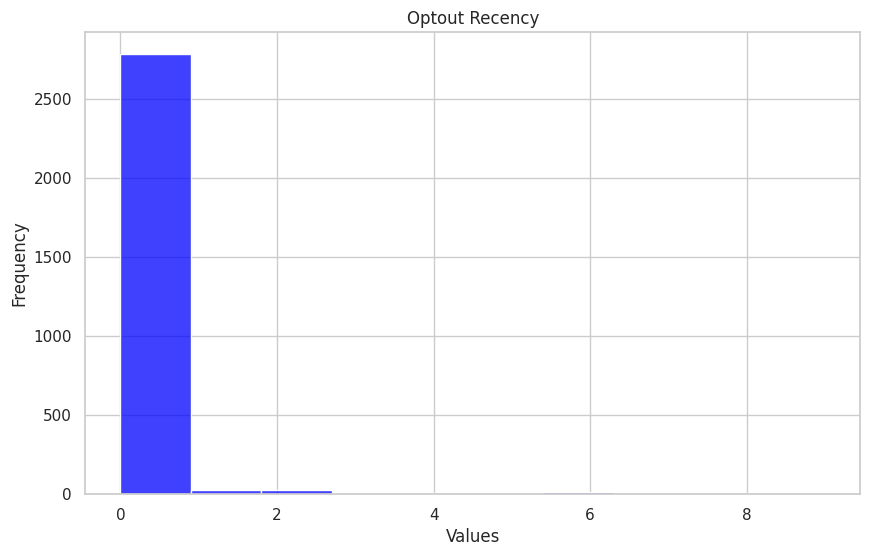

In [60]:
check_enrollment=enrollment[enrollment['optout_recency'] >= 0]


sns.set(style="whitegrid")

# Create a histogram using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(check_enrollment['optout_recency'], bins=10, kde=False, color='blue')

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Optout Recency')

# Show the plot
plt.show()

/var/tmp/ipykernel_7219/2429460206.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  enrollment['optout_recency'].fillna(-10, inplace=True)


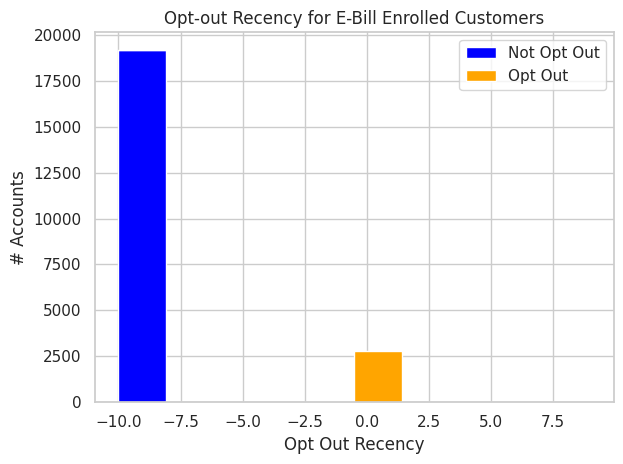

In [61]:
enrollment['optout_recency'].fillna(-10, inplace=True)
group1 = enrollment[enrollment['optout_recency'] < 0]['optout_recency']
group2 = enrollment[enrollment['optout_recency'] >= 0]['optout_recency']

# Plot histogram with different colors for each group
plt.hist([group1, group2], bins=10, stacked=True, color=['blue', 'orange'], label=['Not Opt Out', 'Opt Out'])
plt.xlabel('Opt Out Recency')
plt.ylabel('# Accounts')
plt.title('Opt-out Recency for E-Bill Enrolled Customers')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


   optout_recency_tier  record count  record pct
0          a.no optout         19309    0.869618
1  b1.optout 1-30 days          2895    0.130382


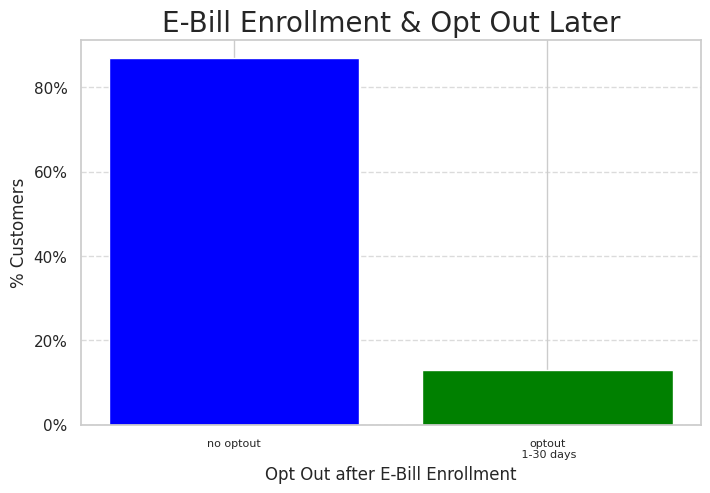

In [62]:
def assign_tier(optout_recency):
    if optout_recency < 0:
        return 'a.no optout'
    elif optout_recency < 30:
        return 'b1.optout 1-30 days'
    elif optout_recency < 60: 
        return 'b2.optout 31-60 days'
    elif optout_recency < 90: 
        return 'b3.optout 61-90 days'
    elif optout_recency < 180: 
        return 'b4.optout 91-180 days'
    else: 
        return 'b5.optout 180+ days'
    
enrollment['optout_recency_tier']=enrollment['optout_recency'].apply(assign_tier)
sum_tier=enrollment.groupby('optout_recency_tier').size().reset_index()
sum_tier.columns=['optout_recency_tier', 'record count']

sum_tier['record pct']=sum_tier['record count']/len(enrollment)
print(sum_tier)

# categories=['no optout', 'optout 1-30 days', 'optout 31-60 days', 'optout 61-90 days', 'optout 91-180 days',  'optout 180+ days']
categories=['no optout', 'optout 1-30 days']
wrapped_labels = [label.replace("optout", "optout\n") for label in categories]
colors=['blue']+['green']*(len(categories)-1)

# Create the bar chart
plt.figure(figsize=(8, 5))
#plt.bar(sum_tier['optout_recency_tier'], sum_tier['record pct'], color='skyblue')
plt.bar(wrapped_labels, sum_tier['record pct'], color=colors)
plt.xlabel('Opt Out after E-Bill Enrollment')
plt.ylabel('% Customers')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.xticks(rotation=0, fontsize=8)
plt.title('E-Bill Enrollment & Opt Out Later', fontsize=20)
plt.grid(axis='y', linestyle='--', alpha=0.7)

In [63]:
enrollment.to_csv(str(path_name)+str('/enrollment.csv'), index=False)

## 2 - Extract data from Snowflake
* We need to pull data by segment due to limited computing power in both Snowflake and GCP. 
* The segmented data will be merged later. 

#### 2.1.1 - ContractAccount Level count variable

In [64]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_30D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_30D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_60D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_60D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_90D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_90D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
full outer join 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_180D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_180D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) d
on a.ev_obj_nbr=d.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_360D') as event_type, count(*) as ev_type_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_CT_360D')
)
PIVOT (max(ev_type_count) for event_type in (
    select distinct concat(ev_type, '_CA_CT_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) e
on a.ev_obj_nbr=e.ev_obj_nbr
where e.ev_obj_nbr > 0

"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6742461 entries, 0 to 6742460
Data columns (total 31 columns):
 #   Column            Dtype  
---  ------            -----  
 0   cact              object 
 1   inpl_ca_ct_30d    float64
 2   invce_ca_ct_30d   float64
 3   lock_ca_ct_30d    float64
 4   pcomm_ca_ct_30d   float64
 5   pred_ca_ct_30d    float64
 6   pymt_ca_ct_30d    float64
 7   inpl_ca_ct_60d    float64
 8   invce_ca_ct_60d   float64
 9   lock_ca_ct_60d    float64
 10  pcomm_ca_ct_60d   float64
 11  pred_ca_ct_60d    float64
 12  pymt_ca_ct_60d    float64
 13  inpl_ca_ct_90d    float64
 14  invce_ca_ct_90d   float64
 15  lock_ca_ct_90d    float64
 16  pcomm_ca_ct_90d   float64
 17  pred_ca_ct_90d    float64
 18  pymt_ca_ct_90d    float64
 19  inpl_ca_ct_180d   float64
 20  invce_ca_ct_180d  float64
 21  lock_ca_ct_180d   float64
 22  pcomm_ca_ct_180d  float64
 23  pred_ca_ct_180d   float64
 24  pymt_ca_ct_180d   float64
 25  inpl_ca_ct_360d   floa

In [65]:
df.to_csv(str(path_name)+str('/CACT_event_ct.csv'), index=False)

In [66]:
df.head()

,cact,inpl_ca_ct_30d,invce_ca_ct_30d,lock_ca_ct_30d,pcomm_ca_ct_30d,pred_ca_ct_30d,pymt_ca_ct_30d,inpl_ca_ct_60d,invce_ca_ct_60d,lock_ca_ct_60d,pcomm_ca_ct_60d,pred_ca_ct_60d,pymt_ca_ct_60d,inpl_ca_ct_90d,invce_ca_ct_90d,lock_ca_ct_90d,pcomm_ca_ct_90d,pred_ca_ct_90d,pymt_ca_ct_90d,inpl_ca_ct_180d,invce_ca_ct_180d,lock_ca_ct_180d,pcomm_ca_ct_180d,pred_ca_ct_180d,pymt_ca_ct_180d,inpl_ca_ct_360d,invce_ca_ct_360d,lock_ca_ct_360d,pcomm_ca_ct_360d,pred_ca_ct_360d,pymt_ca_ct_360d
0,700977773481,NaN,1.0,1.0,NaN,NaN,1.0,NaN,2.0,3.0,NaN,NaN,2.0,NaN,3.0,6.0,NaN,NaN,3.0,NaN,3.0,6.0,NaN,NaN,3.0,NaN,3.0,6.0,NaN,NaN,3.0
1,700978436418,NaN,1.0,1.0,NaN,NaN,1.0,NaN,2.0,3.0,NaN,NaN,2.0,NaN,2.0,4.0,NaN,NaN,2.0,NaN,2.0,4.0,NaN,NaN,2.0,NaN,2.0,4.0,NaN,NaN,2.0
2,700978140263,NaN,1.0,2.0,NaN,NaN,1.0,NaN,2.0,4.0,NaN,NaN,2.0,NaN,2.0,5.0,NaN,NaN,2.0,NaN,2.0,5.0,NaN,NaN,2.0,NaN,2.0,5.0,NaN,NaN,2.0
3,700978564033,NaN,1.0,2.0,NaN,NaN,1.0,NaN,2.0,4.0,NaN,NaN,2.0,NaN,3.0,7.0,NaN,NaN,3.0,NaN,3.0,7.0,NaN,NaN,3.0,NaN,3.0,7.0,NaN,NaN,3.0
4,700978850080,NaN,1.0,1.0,NaN,NaN,1.0,NaN,2.0,2.0,NaN,NaN,2.0,NaN,3.0,4.0,NaN,NaN,3.0,NaN,3.0,4.0,NaN,NaN,3.0,NaN,3.0,4.0,NaN,NaN,3.0


#### 2.1.2 - ContractAccount Level recency

In [67]:
# recency in past 365 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select ev_obj_nbr as cact, * from 
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_recency') as event_type, 
        min(datediff(day, to_date(EV_TYPE_VAL_DT_1), '2025-08-11')) as ev_type_recency
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  AND to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -365, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_recency')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_recency')
)
PIVOT (max(ev_type_recency) for event_type in (
    select distinct concat(ev_type, '_CA_recency')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
    and EV_TYPE_VAL_DT_1 between DATEADD(day, -365, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6754420 entries, 0 to 6754419
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   cact              object 
 1   inpl_ca_recency   float64
 2   invce_ca_recency  float64
 3   lock_ca_recency   float64
 4   pcomm_ca_recency  float64
 5   pred_ca_recency   float64
 6   pymt_ca_recency   float64
dtypes: float64(6), object(1)
memory usage: 360.7+ MB


In [68]:
df.to_csv(str(path_name)+str('/CACT_event_recency.csv'), index=False)

#### 2.1.3 - event amount

In [69]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_30D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_30D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_60D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_60D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_90D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_90D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
full outer join 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_180D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_180D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) d
on a.ev_obj_nbr=d.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_360D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, '_CA_AM_360D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, '_CA_AM_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) e
on a.ev_obj_nbr=e.ev_obj_nbr
where e.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6742461 entries, 0 to 6742460
Data columns (total 31 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   cact              object
 1   inpl_ca_am_30d    object
 2   invce_ca_am_30d   object
 3   lock_ca_am_30d    object
 4   pcomm_ca_am_30d   object
 5   pred_ca_am_30d    object
 6   pymt_ca_am_30d    object
 7   inpl_ca_am_60d    object
 8   invce_ca_am_60d   object
 9   lock_ca_am_60d    object
 10  pcomm_ca_am_60d   object
 11  pred_ca_am_60d    object
 12  pymt_ca_am_60d    object
 13  inpl_ca_am_90d    object
 14  invce_ca_am_90d   object
 15  lock_ca_am_90d    object
 16  pcomm_ca_am_90d   object
 17  pred_ca_am_90d    object
 18  pymt_ca_am_90d    object
 19  inpl_ca_am_180d   object
 20  invce_ca_am_180d  object
 21  lock_ca_am_180d   object
 22  pcomm_ca_am_180d  object
 23  pred_ca_am_180d   object
 24  pymt_ca_am_180d   object
 25  inpl_ca_am_360d   object
 26  invce_ca_am_360d  o

In [70]:
df.to_csv(str(path_name)+str('/CACT_event_amt.csv'), index=False)

#### 2.2.1 - subtype count
* Snowflake-GCP pipeline has a bottleneck with regard to how much data an be transported. 
* Therefore, we divided the data extraction into two steps. 

In [5]:
#1-90 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_30') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_30')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_30')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_30')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_60') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_60')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_60')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_60')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_90') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_90')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_90')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_90')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
where c.ev_obj_nbr > 0

"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5719706 entries, 0 to 5719705
Data columns (total 67 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   cact                            object 
 1   cact-dunn_ca_sub_ct_30          float64
 2   cact-intr_ca_sub_ct_30          float64
 3   cact-inv_ca_sub_ct_30           float64
 4   cact-ipymt_ca_sub_ct_30         float64
 5   cact-opymt_ca_sub_ct_30         float64
 6   cact-post_ca_sub_ct_30          float64
 7   cleared_ca_sub_ct_30            float64
 8   closed_ca_sub_ct_30             float64
 9   collprop_ca_sub_ct_30           float64
 10  create_ca_sub_ct_30             float64
 11  deactive_ca_sub_ct_30           float64
 12  fica-dunn_ca_sub_ct_30          float64
 13  fica-intr_ca_sub_ct_30          float64
 14  fica-post_ca_sub_ct_30          float64
 15  fica-pymt_ca_sub_ct_30          float64
 16  ip_amp_paymentdue_ca_sub_ct_30  float64
 17  mimo

In [6]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_ct_1.csv'), index=False)

In [7]:
# 180-360 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_180') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_180')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_180')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_180')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) d
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_360') as event_subtype, count(*) as ev_subtype_count
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_360')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_CT_360')
)
PIVOT (max(ev_subtype_count) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_CT_360')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) e
on d.ev_obj_nbr=e.ev_obj_nbr
where e.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6742461 entries, 0 to 6742460
Data columns (total 45 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   cact                             object 
 1   cact-dunn_ca_sub_ct_180          float64
 2   cact-intr_ca_sub_ct_180          float64
 3   cact-inv_ca_sub_ct_180           float64
 4   cact-ipymt_ca_sub_ct_180         float64
 5   cact-opymt_ca_sub_ct_180         float64
 6   cact-post_ca_sub_ct_180          float64
 7   cleared_ca_sub_ct_180            float64
 8   closed_ca_sub_ct_180             float64
 9   collprop_ca_sub_ct_180           float64
 10  create_ca_sub_ct_180             float64
 11  deactive_ca_sub_ct_180           float64
 12  fica-dunn_ca_sub_ct_180          float64
 13  fica-intr_ca_sub_ct_180          float64
 14  fica-post_ca_sub_ct_180          float64
 15  fica-pymt_ca_sub_ct_180          float64
 16  ip_amp_paymentdue_ca_sub_ct_180

In [8]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_ct_2.csv'), index=False)

#### 2.2.2 - subtype recency

In [9]:
# recency in past 365 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select ev_obj_nbr as cact, * from 
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_recency') as event_subtype, 
        min(datediff(day, to_date(EV_TYPE_VAL_DT_1), '2025-08-11')) as ev_sub_recency
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  AND to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -365, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_recency')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_recency')
)
PIVOT (max(ev_sub_recency) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_recency')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
    and EV_TYPE_VAL_DT_1 between DATEADD(day, -365, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)
where ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6754420 entries, 0 to 6754419
Data columns (total 23 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   cact                              object 
 1   cact-dunn_ca_sub_recency          float64
 2   cact-intr_ca_sub_recency          float64
 3   cact-inv_ca_sub_recency           float64
 4   cact-ipymt_ca_sub_recency         float64
 5   cact-opymt_ca_sub_recency         float64
 6   cact-post_ca_sub_recency          float64
 7   cleared_ca_sub_recency            float64
 8   closed_ca_sub_recency             float64
 9   collprop_ca_sub_recency           float64
 10  create_ca_sub_recency             float64
 11  deactive_ca_sub_recency           float64
 12  fica-dunn_ca_sub_recency          float64
 13  fica-intr_ca_sub_recency          float64
 14  fica-post_ca_sub_recency          float64
 15  fica-pymt_ca_sub_recency          float64
 16  ip_amp_paymen

In [10]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_recency.csv'), index=False)

#### 2.2.3 - subtype amount

In [11]:
#1-90 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_30') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_30')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_30')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_30')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_60') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_60')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_60')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_60')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_90') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_90')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_90')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_90')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
where c.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5719706 entries, 0 to 5719705
Data columns (total 67 columns):
 #   Column                          Dtype 
---  ------                          ----- 
 0   cact                            object
 1   cact-dunn_ca_sub_am_30          object
 2   cact-intr_ca_sub_am_30          object
 3   cact-inv_ca_sub_am_30           object
 4   cact-ipymt_ca_sub_am_30         object
 5   cact-opymt_ca_sub_am_30         object
 6   cact-post_ca_sub_am_30          object
 7   cleared_ca_sub_am_30            object
 8   closed_ca_sub_am_30             object
 9   collprop_ca_sub_am_30           object
 10  create_ca_sub_am_30             object
 11  deactive_ca_sub_am_30           object
 12  fica-dunn_ca_sub_am_30          object
 13  fica-intr_ca_sub_am_30          object
 14  fica-post_ca_sub_am_30          object
 15  fica-pymt_ca_sub_am_30          object
 16  ip_amp_paymentdue_ca_sub_am_30  object
 17  mimo_day_before_ca_sub_

In [12]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_am_1.csv'), index=False)

In [13]:
#180-365 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select e.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_180') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_180')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_180')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_180')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) d
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_360') as event_subtype, sum(ev_type_val_nbr) as ev_subtype_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_360')
order by EV_OBJ, ev_obj_nbr, concat(ev_sub_type, '_CA_sub_AM_360')
)
PIVOT (max(ev_subtype_amt) for event_subtype in (
    select distinct concat(ev_sub_type, '_CA_sub_AM_360')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) e
on d.ev_obj_nbr=e.ev_obj_nbr
and e.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6742461 entries, 0 to 6742460
Data columns (total 45 columns):
 #   Column                           Dtype 
---  ------                           ----- 
 0   cact                             object
 1   cact-dunn_ca_sub_am_180          object
 2   cact-intr_ca_sub_am_180          object
 3   cact-inv_ca_sub_am_180           object
 4   cact-ipymt_ca_sub_am_180         object
 5   cact-opymt_ca_sub_am_180         object
 6   cact-post_ca_sub_am_180          object
 7   cleared_ca_sub_am_180            object
 8   closed_ca_sub_am_180             object
 9   collprop_ca_sub_am_180           object
 10  create_ca_sub_am_180             object
 11  deactive_ca_sub_am_180           object
 12  fica-dunn_ca_sub_am_180          object
 13  fica-intr_ca_sub_am_180          object
 14  fica-post_ca_sub_am_180          object
 15  fica-pymt_ca_sub_am_180          object
 16  ip_amp_paymentdue_ca_sub_am_180  object
 17  mimo

In [14]:
df.to_csv(str(path_name)+str('/CACT_event_subtype_am_2.csv'), index=False)

#### 2.3 - event type and subtype combined

#### 2.3.1 - count

In [15]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5831582 entries, 0 to 5831581
Data columns (total 73 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   cact                               object 
 1   inplZcleared_ca_ct_30d             float64
 2   inplZclosed_ca_ct_30d              float64
 3   inplZcreate_ca_ct_30d              float64
 4   inplZdeactive_ca_ct_30d            float64
 5   inplZoverdue_ca_ct_30d             float64
 6   invceZcreate_ca_ct_30d             float64
 7   invceZrever_ca_ct_30d              float64
 8   lockZcact-dunn_ca_ct_30d           float64
 9   lockZcact-intr_ca_ct_30d           float64
 10  lockZcact-inv_ca_ct_30d            float64
 11  lockZcact-ipymt_ca_ct_30d          float64
 12  lockZcact-opymt_ca_ct_30d          float64
 13  lockZcact-post_ca_ct_30d           float64
 14  lockZfica-dunn_ca_ct_30d           float64
 15  lockZfica-intr_ca_ct_30d           float64


In [16]:
df.to_csv(str(path_name)+str('/CACT_event_com_ct_1.csv'), index=False)

In [17]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select b.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D') as event_type, count(ev_type_val_nbr) as ev_type_ct
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D')
)
PIVOT (max(ev_type_ct) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_CT_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
where b.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6742461 entries, 0 to 6742460
Data columns (total 49 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   cact                                object 
 1   inplZcleared_ca_ct_180d             float64
 2   inplZclosed_ca_ct_180d              float64
 3   inplZcreate_ca_ct_180d              float64
 4   inplZdeactive_ca_ct_180d            float64
 5   inplZoverdue_ca_ct_180d             float64
 6   invceZcreate_ca_ct_180d             float64
 7   invceZrever_ca_ct_180d              float64
 8   lockZcact-dunn_ca_ct_180d           float64
 9   lockZcact-intr_ca_ct_180d           float64
 10  lockZcact-inv_ca_ct_180d            float64
 11  lockZcact-ipymt_ca_ct_180d          float64
 12  lockZcact-opymt_ca_ct_180d          float64
 13  lockZcact-post_ca_ct_180d           float64
 14  lockZfica-dunn_ca_ct_180d           float64
 15  lockZfica-intr_ca_ct_180d 

In [18]:
df.shape

(6742461, 49)

In [19]:
df.to_csv(str(path_name)+str('/CACT_event_com_ct_2.csv'), index=False)

#### 2.3.2 - recency

In [20]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select ev_obj_nbr as cact, * from 
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_recency') as event_type, 
        min(datediff(day, to_date(EV_TYPE_VAL_DT_1), '2025-08-11')) as ev_type_recency
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  AND to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -365, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_recency')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_recency')
)
PIVOT (max(ev_type_recency) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_recency')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
    and EV_TYPE_VAL_DT_1 between DATEADD(day, -365, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6754420 entries, 0 to 6754419
Data columns (total 25 columns):
 #   Column                              Dtype  
---  ------                              -----  
 0   cact                                object 
 1   inplZcleared_ca_recency             float64
 2   inplZclosed_ca_recency              float64
 3   inplZcreate_ca_recency              float64
 4   inplZdeactive_ca_recency            float64
 5   inplZoverdue_ca_recency             float64
 6   invceZcreate_ca_recency             float64
 7   invceZrever_ca_recency              float64
 8   lockZcact-dunn_ca_recency           float64
 9   lockZcact-intr_ca_recency           float64
 10  lockZcact-inv_ca_recency            float64
 11  lockZcact-ipymt_ca_recency          float64
 12  lockZcact-opymt_ca_recency          float64
 13  lockZcact-post_ca_recency           float64
 14  lockZfica-dunn_ca_recency           float64
 15  lockZfica-intr_ca_recency 

In [21]:
df.to_csv(str(path_name)+str('/CACT_event_com_recency.csv'), index=False)

#### 2.3.3 - amount

In [ ]:
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select c.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_30D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -31, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_60D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -61, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT'  and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_90D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -91, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) c
on a.ev_obj_nbr=c.ev_obj_nbr

"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

Connection successful.


In [ ]:
df.to_csv(str(path_name)+str('/CACT_event_com_am_1.csv'), index=False)

In [ ]:
# recency in past 365 days
PROJECT_ID = "sceg-d-prj-dxg-002" # repoint to sandbox environment
vertexai.init(project=PROJECT_ID, location="us-central1")
fid_secret_string = access_secret_version(PROJECT_ID, "fid_cred")
# Load functional id credentials from the secret JSON string
functional_id_info = json.loads(fid_secret_string)
# Extract the absolute path to the key file from the JSON
fid_key_path = "/tmp/fid_key.json"  # Create a temporary file path in the container
with open(fid_key_path, "w") as f:
    json.dump(functional_id_info, f)
# SNOWPARK SESSION CONNECTOR
# Define your Snowflake connection parameters
connection_parameters = {
    "account": "edwsce.west-us-2.azure",
    "user": functional_id_info["FID_USER"],
    "password": functional_id_info["FID_PASS"],
    "authenticator": "https://eix.okta.com",
    "warehouse": "PROD_IT_CS_CNSMPADHOCWH13",
    "database": "PROD_IT_SS",
    "schema": "IT_DPT_SS"
}
max_retries = 3
retry_count = 0
while retry_count < max_retries:
    try:
        # Create a Snowpark session
        session = Session.builder.configs(connection_parameters).create()
        print("Connection successful.")
        # log print      
        #log_message(f'Snowpark Snowflake connection successful, reading transcripts.', log_file_name, bucket_name, log_folder)
        break
    except Exception as e:
        retry_count += 1
        print(f"Snowflake connection failed: {e}")
        if retry_count < max_retries:
            print(f"Retrying {retry_count}/{max_retries}...")
            time.sleep(3)  # Wait for 3 seconds before retrying
        else:
            print("Max retries reached. Exiting.")
            # log print      
            #log_message(f'Snowpark Snowflake connection failed.', log_file_name, bucket_name, log_folder)

sql_query = f"""
select b.ev_obj_nbr as cact, * from 
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_180D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and EV_TYPE_VAL_DT_1 between DATEADD(day, -181, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) a
full outer join
(select * from
(select EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D') as event_type, sum(ev_type_val_nbr) as ev_type_amt
from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS 
where ev_obj='CONTRACT_ACCT' and ev_obj_nbr > 0
  and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11')
group by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D')
order by EV_OBJ, ev_obj_nbr, concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D')
)
PIVOT (max(ev_type_amt) for event_type in (
    select distinct concat(ev_type, 'z', ev_sub_type, '_CA_AM_360D')
    from PROD_CS_SS.CS_CSOD_BIC_SS.CS_EVENTS
    where ev_obj='CONTRACT_ACCT' 
      and to_date(EV_TYPE_VAL_DT_1) between DATEADD(day, -361, '2025-08-11') and DATEADD(day, -1, '2025-08-11'))
)) b
on a.ev_obj_nbr=b.ev_obj_nbr
where b.ev_obj_nbr > 0
"""

# Execute the query and collect the result
snow_input = session.sql(sql_query).collect()
# Convert the result to a pandas DataFrame
df = pd.DataFrame(snow_input)
df.columns = df.columns.str.replace("'", '')
df=df.drop(columns=[col for col in df.columns if col.startswith('EV_OBJ')])
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace("z", 'Z')
df.info()

In [ ]:
df.to_csv(str(path_name)+str('/CACT_event_com_am_2.csv'), index=False)

## Part 3 - combine data
#### 3.1 - find customers with emails

In [5]:
all_resi_model=pd.read_csv(str(path_name)+str('/all_resi_model.csv'))
all_resi_model.drop_duplicates(subset='cact', keep='first', inplace=True)
all_resi_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4583648 entries, 0 to 4685110
Data columns (total 15 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cact           int64 
 1   bp             int64 
 2   rate_plan      object
 3   rate_plan_cat  object
 4   unit_num       int64 
 5   landline       int64 
 6   mobilephone    int64 
 7   having_phone   int64 
 8   cust_type      object
 9   critical_care  object
 10  cactnum        int64 
 11  movein_date    object
 12  moveoutdate    object
 13  bill_type      object
 14  have_email     int64 
dtypes: int64(8), object(7)
memory usage: 559.5+ MB


In [6]:
# match with email address
email_myacct=pd.read_csv(str(path_name)+str('/email_myacct.csv'))
email_myacct.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6341299 entries, 0 to 6341298
Data columns (total 5 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   cact              int64 
 1   bp                int64 
 2   email_valid_from  object
 3   email_valid_to    object
 4   email             object
dtypes: int64(2), object(3)
memory usage: 241.9+ MB


In [7]:
email_contact=pd.read_csv(str(path_name)+str('/email_contact.csv'))
email_contact.info()

/var/tmp/ipykernel_7506/283552811.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  email_contact=pd.read_csv(str(path_name)+str('/email_contact.csv'))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10535471 entries, 0 to 10535470
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   bp                  object
 1   ZCOMM_VALIDFRM      object
 2   ZCOMM_VALIDTO       object
 3   bp_email            object
 4   email_contact_from  object
 5   email_contact_to    object
dtypes: object(6)
memory usage: 482.3+ MB


In [8]:
# merge by email
email_myacct.drop_duplicates(subset=['bp', 'cact', 'email'], keep='first', inplace=True)
email_myacct['email']=email_myacct['email'].str.strip()  # remove extra space for later merging
print(email_myacct.shape)

email_contact.drop_duplicates(subset=['bp', 'bp_email'], keep='first', inplace=True)
email_contact.rename(columns={'bp_email': 'email'}, inplace=True)
email_contact['email']=email_contact['email'].str.strip() # remove extra space for later merging
print(email_contact.shape)

(6333735, 5)
(9545920, 6)


In [9]:
email_contact.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9545920 entries, 0 to 10535470
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   bp                  object
 1   ZCOMM_VALIDFRM      object
 2   ZCOMM_VALIDTO       object
 3   email               object
 4   email_contact_from  object
 5   email_contact_to    object
dtypes: object(6)
memory usage: 509.8+ MB


In [10]:
email_myacct_contact=pd.merge(email_myacct[['bp', 'cact', 'email']], email_contact[['bp', 'email']], on=['bp', 'email'], how='outer')
print(email_myacct_contact.shape)
email_myacct_contact.info()

email_myacct_contact.drop_duplicates(subset=['bp', 'cact', 'email'], keep='first', inplace=True)
email_count_cact=email_myacct_contact.groupby(['bp', 'cact'])['email'].nunique().reset_index().rename(columns={'email': 'email_cnt_cact'})
bp_cact_count=email_myacct_contact.groupby('bp')['cact'].nunique().reset_index().rename(columns={'cact': 'cact_cnt'})
print(email_count_cact.shape)

email_count_bp=email_myacct_contact.groupby('bp')['email'].nunique().reset_index().rename(columns={'email': 'email_cnt_bp'})
print(email_count_bp.shape)

(14775961, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14775961 entries, 0 to 14775960
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   bp      object 
 1   cact    float64
 2   email   object 
dtypes: float64(1), object(2)
memory usage: 338.2+ MB
(5681880, 3)
(8744450, 2)


In [11]:
bp_email=pd.merge(bp_cact_count, email_count_bp, on='bp', how='outer') 
email_info=pd.merge(bp_email, email_count_cact, on='bp', how='outer') 
email_info.info() 
email_info.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969086 entries, 0 to 9969085
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bp              object 
 1   cact_cnt        int64  
 2   email_cnt_bp    int64  
 3   cact            float64
 4   email_cnt_cact  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 380.3+ MB


,bp,cact_cnt,email_cnt_bp,cact,email_cnt_cact
0,1000000018,0,1,NaN,NaN
1,1000000019,1,1,4.000000e+11,1.0
2,1000000026,0,1,NaN,NaN
3,1000000027,0,4,NaN,NaN
4,1000000028,3,6,7.008630e+11,1.0


In [12]:
cact_with_email=email_info[email_info['cact'].isnull()==False]
cact_with_email['with_email']=np.where((cact_with_email['email_cnt_bp'] > 0) | (cact_with_email['email_cnt_cact'] > 0), 1, 0)
cact_with_email=cact_with_email[cact_with_email['with_email'] > 0]
cact_with_email.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5681880 entries, 1 to 7755388
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   bp              object 
 1   cact_cnt        int64  
 2   email_cnt_bp    int64  
 3   cact            float64
 4   email_cnt_cact  float64
 5   with_email      int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 303.4+ MB


/var/tmp/ipykernel_7506/2154396345.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cact_with_email['with_email']=np.where((cact_with_email['email_cnt_bp'] > 0) | (cact_with_email['email_cnt_cact'] > 0), 1, 0)


In [13]:
cact_with_email['cact'].nunique()

5681880

In [14]:
# flag cact with email addresses from MyAccount
cact_with_email.drop('bp', axis=1, inplace=True),
cact_for_model=pd.merge(all_resi_model, cact_with_email, on='cact', how='inner')
cact_for_model.info()
cact_for_model.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3417920 entries, 0 to 3417919
Data columns (total 19 columns):
 #   Column          Dtype  
---  ------          -----  
 0   cact            int64  
 1   bp              int64  
 2   rate_plan       object 
 3   rate_plan_cat   object 
 4   unit_num        int64  
 5   landline        int64  
 6   mobilephone     int64  
 7   having_phone    int64  
 8   cust_type       object 
 9   critical_care   object 
 10  cactnum         int64  
 11  movein_date     object 
 12  moveoutdate     object 
 13  bill_type       object 
 14  have_email      int64  
 15  cact_cnt        int64  
 16  email_cnt_bp    int64  
 17  email_cnt_cact  float64
 18  with_email      int64  
dtypes: float64(1), int64(11), object(7)
memory usage: 495.5+ MB


,cact,bp,rate_plan,rate_plan_cat,unit_num,landline,mobilephone,having_phone,cust_type,critical_care,cactnum,movein_date,moveoutdate,bill_type,have_email,cact_cnt,email_cnt_bp,email_cnt_cact,with_email
0,700363064778,1001065924,D-CARE,D,1,1,1,1,Domestic,No,8000053866,2021-03-08,9999-12-31,EBIL,1,1,3,1.0,1
1,700582573253,1004526277,TOUD-4-9PM-CARE,TD49,1,1,1,1,Domestic,No,8000862346,2021-03-03,9999-12-31,EBIL,1,1,2,1.0,1
2,700009459867,1005381709,TOUD-4-9PM,TD49,1,1,1,1,Domestic,No,8000243818,2021-03-10,9999-12-31,EBIL,1,1,2,1.0,1
3,700088358859,1000689660,DOMESTIC,D,1,1,1,1,Domestic,No,8002066460,2021-03-11,9999-12-31,EBIL,1,1,1,1.0,1
4,700094531291,1003370279,TOUD-5-8PM,TD58,1,1,1,1,Domestic,No,8005071704,2021-03-10,9999-12-31,EBIL,1,1,2,1.0,1


In [15]:
cact_for_model['cact'].nunique()

3417920

In [16]:
cact_for_model.groupby('with_email').size()

with_email
1    3417920
dtype: int64

In [17]:
# Use the SAS file from 06/25/2025 to filter out customers
file_20250626=pd.read_csv(str(path_name)+str('/cact_not_in_ebill_0811.csv'))
file_20250626.rename(columns={'0CACONT_ACC': 'cact'}, inplace=True)
file_20250626.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1813759 entries, 0 to 1813758
Data columns (total 14 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   0FC_ACCNTBP           int64 
 1   cact                  int64 
 2   0UCCONTRACT           int64 
 3   0UCACC_CLAS           object
 4   0FC_STRAT             object
 5   0FCACTDETID           object
 6   ZSCTRL_GP             object
 7   4ZMD_A008_HOUSE_NUM1  object
 8   ZCMPOBCDE             object
 9   4ZMD_A008_STREET      object
 10  4ZMD_A008_CITY1       object
 11  ZMSTATE               object
 12  4ZMD_A008_POST_CODE1  object
 13  4ZMD_A008_COUNTRY     object
dtypes: int64(3), object(11)
memory usage: 193.7+ MB


In [18]:
file_20250626.groupby('ZSCTRL_GP').size()

ZSCTRL_GP
CHKF     116522
CSV          38
EDI        2176
HCB     1413050
TAUD         15
TBRL        184
TLGF       1021
TMBA          2
TMLA          9
TMLB          3
dtype: int64

In [19]:
file_20250626.groupby('0UCACC_CLAS').size()

0UCACC_CLAS
COMM         30
HOLD          1
INDL         12
PAUT          8
RAIL         35
RESI    1813655
SCIC          2
SECD         10
STTC          3
SUPR          3
dtype: int64

In [20]:
file_20250626_clean=file_20250626[file_20250626['0UCACC_CLAS'].str.strip()=='RESI']
file_20250626_clean.drop_duplicates(subset='cact', keep='first', inplace=True)

/var/tmp/ipykernel_7506/1955551531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file_20250626_clean.drop_duplicates(subset='cact', keep='first', inplace=True)


In [21]:
file_prepare=pd.merge(cact_with_email.assign(alec=1), file_20250626_clean.assign(nicole=1), on='cact', how='outer')
file_prepare['alec'].fillna(0, inplace=True)
file_prepare['nicole'].fillna(0, inplace=True)

/var/tmp/ipykernel_7506/1766326681.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  file_prepare['alec'].fillna(0, inplace=True)
/var/tmp/ipykernel_7506/1766326681.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

In [22]:
file_prepare[['alec', 'nicole']].describe()

,alec,nicole
count,6.800352e+06,6.800352e+06
mean,8.355273e-01,2.613796e-01
std,3.707040e-01,4.393863e-01
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00
50%,1.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00
max,1.000000e+00,1.000000e+00


Text(0.5, 1.0, '2x2 Confusion Matrix')

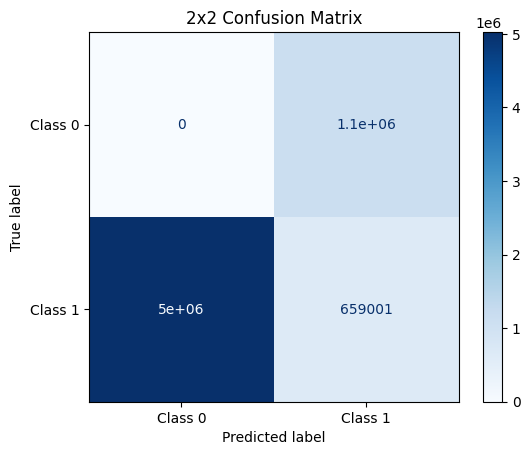

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(file_prepare['alec'], file_prepare['nicole'], labels=[0, 1])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])
disp.plot(cmap=plt.cm.Blues)
plt.title("2x2 Confusion Matrix")

In [24]:
file_prepare.groupby(['alec', 'nicole']).size()

alec  nicole
0.0   1.0       1118472
1.0   0.0       5022879
      1.0        659001
dtype: int64

In [25]:
# Generate 2x2 pivot table (confusion matrix style)
pivot_table=pd.pivot_table(file_prepare[['alec', 'nicole']], index='alec', columns='nicole', aggfunc=len, fill_value=0)
print(pivot_table)

nicole      0.0      1.0
alec                    
0.0           0  1118472
1.0     5022879   659001


#### 3.2 - customers who have enrolled before the cutoff data

In [26]:
current_enroll=pd.read_csv(str(path_name)+str('/enrollment.csv'))
current_enroll['cact']=pd.to_numeric(current_enroll['cact'], errors='coerce')
current_enroll.info()
current_enroll.head()

print(current_enroll['enroll_date'].min())
print(current_enroll['enroll_date'].max())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22204 entries, 0 to 22203
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   cact                 22204 non-null  int64  
 1   enroll_date          22204 non-null  object 
 2   optout_date          3028 non-null   object 
 3   optout_recency       22204 non-null  float64
 4   optout_recency_tier  22204 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 867.5+ KB
2025-08-11
2025-08-20


##### define y

In [27]:
current_enroll['y']=np.where(current_enroll['optout_date'].isnull()==False, 0, 1)
current_enroll['y'].mean()

np.float64(0.8636281751035849)

In [28]:
past_enroll=pd.read_csv(str(path_name)+str('/past_enroll.csv'))
past_optout=pd.read_csv(str(path_name)+str('/past_optout.csv'))

In [29]:
past_enroll['cact']=pd.to_numeric(past_enroll['cact'], errors='coerce')
past_optout['cact']=pd.to_numeric(past_optout['cact'], errors='coerce')
past_optout.info()
past_optout.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878991 entries, 0 to 878990
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   878991 non-null  int64 
 1   latest_optout_date     878991 non-null  object
 2   last_optout_recency    878991 non-null  int64 
 3   opt_out_cnt_total      878991 non-null  int64 
 4   optout_cnt_lastyear    878991 non-null  int64 
 5   optout_cnt_last2years  878991 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 40.2+ MB


,cact,latest_optout_date,last_optout_recency,opt_out_cnt_total,optout_cnt_lastyear,optout_cnt_last2years
0,700827953143,2023-09-21,690,1,0,1
1,700661692315,2023-06-24,779,1,0,0
2,700808980953,2025-04-12,121,1,1,1
3,700888235916,2025-07-04,38,8,8,8
4,700592633466,2025-02-26,166,2,1,1


In [30]:
past_enroll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3105204 entries, 0 to 3105203
Data columns (total 6 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   cact                   int64 
 1   past_enroll_date       object
 2   past_enroll_recency    int64 
 3   enroll_cnt_total       int64 
 4   enroll_cnt_lastyear    int64 
 5   enroll_cnt_last2years  int64 
dtypes: int64(5), object(1)
memory usage: 142.1+ MB


In [31]:
print(past_optout['latest_optout_date'].min())
print(past_optout['latest_optout_date'].max())

2021-04-06
2025-08-10


In [32]:
past_optout.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878991 entries, 0 to 878990
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   cact                   878991 non-null  int64 
 1   latest_optout_date     878991 non-null  object
 2   last_optout_recency    878991 non-null  int64 
 3   opt_out_cnt_total      878991 non-null  int64 
 4   optout_cnt_lastyear    878991 non-null  int64 
 5   optout_cnt_last2years  878991 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 40.2+ MB


In [33]:
# merge three files
dfs=[file_prepare[['cact', 'nicole', 'alec']], current_enroll, past_enroll, past_optout]

merged_enroll = reduce(lambda left, right: pd.merge(left, right, on='cact', how='outer'), dfs)
merged_enroll.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080746 entries, 0 to 7080745
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   cact                   float64
 1   nicole                 float64
 2   alec                   float64
 3   enroll_date            object 
 4   optout_date            object 
 5   optout_recency         float64
 6   optout_recency_tier    object 
 7   y                      float64
 8   past_enroll_date       object 
 9   past_enroll_recency    float64
 10  enroll_cnt_total       float64
 11  enroll_cnt_lastyear    float64
 12  enroll_cnt_last2years  float64
 13  latest_optout_date     object 
 14  last_optout_recency    float64
 15  opt_out_cnt_total      float64
 16  optout_cnt_lastyear    float64
 17  optout_cnt_last2years  float64
dtypes: float64(13), object(5)
memory usage: 972.4+ MB


In [34]:
print(cact_for_model['cact'].count(), cact_for_model['cact'].nunique())
print(file_prepare['cact'].count(), file_prepare['cact'].nunique())
print(current_enroll['cact'].count(), current_enroll['cact'].nunique())
print(past_enroll['cact'].count(), past_enroll['cact'].nunique())
print(past_optout['cact'].count(), past_optout['cact'].nunique())
merged_enroll['cact'].nunique()

3417920 3417920
6800352 6800352
22204 22204
3105204 3105204
878991 878991


7080746

In [35]:
# Use Nicole's definition for customers with active accounts back on 06/25/2025
for_modeling=pd.merge(cact_for_model, merged_enroll, on='cact', how='outer')
for_modeling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080746 entries, 0 to 7080745
Data columns (total 36 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   cact                   float64
 1   bp                     float64
 2   rate_plan              object 
 3   rate_plan_cat          object 
 4   unit_num               float64
 5   landline               float64
 6   mobilephone            float64
 7   having_phone           float64
 8   cust_type              object 
 9   critical_care          object 
 10  cactnum                float64
 11  movein_date            object 
 12  moveoutdate            object 
 13  bill_type              object 
 14  have_email             float64
 15  cact_cnt               float64
 16  email_cnt_bp           float64
 17  email_cnt_cact         float64
 18  with_email             float64
 19  nicole                 float64
 20  alec                   float64
 21  enroll_date            object 
 22  optout_date       

In [36]:
for_modeling['cact'].nunique()

7080746

In [37]:
for_modeling.groupby('with_email').size()

with_email
1.0    3417920
dtype: int64

In [38]:
for_modeling.groupby('y').size()

y
0.0     3028
1.0    19176
dtype: int64

In [39]:
model_sample=for_modeling[for_modeling['nicole']==1]
model_sample['y'].fillna(0, inplace=True)
model_sample.info()                  

/var/tmp/ipykernel_7506/1208460312.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_sample['y'].fillna(0, inplace=True)
/var/tmp/ipykernel_7506/1208460312.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_sample['y'].fillna(0, inplace=True)


<class 'pandas.core.frame.DataFrame'>
Index: 1777473 entries, 713 to 7070920
Data columns (total 36 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   cact                   float64
 1   bp                     float64
 2   rate_plan              object 
 3   rate_plan_cat          object 
 4   unit_num               float64
 5   landline               float64
 6   mobilephone            float64
 7   having_phone           float64
 8   cust_type              object 
 9   critical_care          object 
 10  cactnum                float64
 11  movein_date            object 
 12  moveoutdate            object 
 13  bill_type              object 
 14  have_email             float64
 15  cact_cnt               float64
 16  email_cnt_bp           float64
 17  email_cnt_cact         float64
 18  with_email             float64
 19  nicole                 float64
 20  alec                   float64
 21  enroll_date            object 
 22  optout_date          

In [40]:
model_sample['cact'].nunique()

1777473

In [41]:
print(model_sample.groupby('y').size())
print(model_sample['y'].mean())

y
0.0    1769287
1.0       8186
dtype: int64
0.004605414540755331


#### 3.2 - append predictors/attributes

In [42]:
excl_exempt=pd.read_csv(str(path_name)+str('/excl_exempt.csv'))
excl_exempt.rename(columns={'ZBP_PART': 'bp'}, inplace=True)
excl_exempt.drop_duplicates(subset='bp', keep='first', inplace=True)
model_sample2=pd.merge(model_sample, excl_exempt[['bp']].assign(exempt=1), on='bp', how='left')
model_sample2['exempt'].fillna(0, inplace=True)
print(model_sample2['exempt'].sum())
print(model_sample2['exempt'].mean())
model_sample2.shape

/var/tmp/ipykernel_7506/3061462453.py:1: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  excl_exempt=pd.read_csv(str(path_name)+str('/excl_exempt.csv'))


70098.0
0.03943688596113696


/var/tmp/ipykernel_7506/3061462453.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_sample2['exempt'].fillna(0, inplace=True)


(1777473, 37)

In [43]:
excl_payment_1yr=pd.read_csv(str(path_name)+str('/excl_payment_1yr.csv'))
excl_payment_1yr.info()

model_sample2=pd.merge(model_sample2, excl_payment_1yr, on='cact', how='left')
model_sample2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4105206 entries, 0 to 4105205
Data columns (total 4 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   cact                  int64 
 1   pymt_type             object
 2   last_pymt_date        object
 3   last_payment_recency  int64 
dtypes: int64(2), object(2)
memory usage: 125.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991548 entries, 0 to 1991547
Data columns (total 40 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   cact                   float64
 1   bp                     float64
 2   rate_plan              object 
 3   rate_plan_cat          object 
 4   unit_num               float64
 5   landline               float64
 6   mobilephone            float64
 7   having_phone           float64
 8   cust_type              object 
 9   critical_care          object 
 10  cactnum                float64
 11  movein_date            object 
 12  moveoutdat

In [44]:
df=pd.read_csv(str(path_name)+str('/payment_type.csv'))

model_sample2=pd.merge(model_sample2, df, on='cact', how='left')
model_sample2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991548 entries, 0 to 1991547
Columns: 228 entries, cact to recency_WO
dtypes: float64(214), object(14)
memory usage: 3.4+ GB


* Due to the large size of each file, we merge it with the model file sequentially. 

In [45]:
df=pd.read_csv(str(path_name)+str('/CACT_event_ct.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_recency.csv'))
df.fillna(600, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_amt.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_ct_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_ct_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_recency.csv'))
df.fillna(600, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_am_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_subtype_am_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_ct_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_ct_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_am_1.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_am_2.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

df=pd.read_csv(str(path_name)+str('/CACT_event_com_recency.csv'))
df.fillna(0, inplace=True)
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')

In [46]:
# read in Acxiom data
df=pd.read_csv('gs://ebill_enrollment_model/input_data/acxiom_202406.csv')
df['cact']=pd.to_numeric(df['CONTRACT_ACCOUNT'], errors='coerce')
df.drop_duplicates(subset='cact', keep='first', inplace=True)
df.drop(['BP',
 'CONTRACT_ACCOUNT',
 'Contract Number',
 'Service Account Number',
 'INSTALLATION_NUMBER',
 'DEVICE_LOCATION',
 'Customer Full Name',
 'Customer First Name',
 'Customer Last Name',
 'PREMISE',
 'Premise Street Address Number',
 'Premise Street Address Name',
 'Premise Street Address Unit',
 'Premise City',
 'Premise State',
 'Premise ZIP Code'], axis=1, inplace=True)
df.columns = df.columns.str.replace("'", '')
df.columns = df.columns.str.replace(".", '')
df.columns = df.columns.str.replace(",", '')
df.columns = df.columns.str.replace("-", '')
df.columns = df.columns.str.replace(" ", '')
df.columns = df.columns.str.replace("(", '')
df.columns = df.columns.str.replace(")", '')
df.columns = df.columns.str.replace("%", '')
df.columns = df.columns.str.replace("/", '')
#df.columns = df.columns.str.replace('\', '')
df.columns = df.columns.str.replace("=", '_')     
df.columns = df.columns.str.replace("+", '')
df.columns = df.columns.str.replace("$", '')
df.columns = df.columns.str.replace("?", '')
df.columns = df.columns.str.replace("+", '')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4458884 entries, 0 to 4491793
Columns: 212 entries, PX001270_01PersonicxLifestageClusterCode170SeeFormatLIFECLS to cact
dtypes: float64(155), int64(2), object(55)
memory usage: 7.1+ GB


In [47]:
model_sample2=pd.merge(model_sample2, df, on='cact', how='left')
model_sample2['y'].fillna(0, inplace=True)

/var/tmp/ipykernel_7506/3106846330.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_sample2['y'].fillna(0, inplace=True)


In [48]:
model_sample2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1991548 entries, 0 to 1991547
Columns: 1011 entries, cact to cnt
dtypes: float64(942), object(69)
memory usage: 15.0+ GB


In [48]:
model_sample2.columns.tolist()

['cact',
 'bp',
 'rate_plan',
 'rate_plan_cat',
 'unit_num',
 'landline',
 'mobilephone',
 'having_phone',
 'cust_type',
 'critical_care',
 'cactnum',
 'movein_date',
 'moveoutdate',
 'bill_type',
 'have_email',
 'cact_cnt',
 'email_cnt_bp',
 'email_cnt_cact',
 'with_email',
 'nicole',
 'alec',
 'enroll_date',
 'optout_date',
 'optout_recency',
 'optout_recency_tier',
 'y',
 'past_enroll_date',
 'past_enroll_recency',
 'enroll_cnt_total',
 'enroll_cnt_lastyear',
 'enroll_cnt_last2years',
 'latest_optout_date',
 'last_optout_recency',
 'opt_out_cnt_total',
 'optout_cnt_lastyear',
 'optout_cnt_last2years',
 'exempt',
 'pymt_type',
 'last_pymt_date',
 'last_payment_recency',
 'count_AM_30',
 'count_CP_30',
 'count_CS_30',
 'count_DP_30',
 'count_ED_30',
 'count_EF_30',
 'count_ER_30',
 'count_HB_30',
 'count_HP_30',
 'count_I1_30',
 'count_IB_30',
 'count_IN_30',
 'count_IR_30',
 'count_J1_30',
 'count_J2_30',
 'count_J4_30',
 'count_J5_30',
 'count_J6_30',
 'count_J7_30',
 'count_ML_30',

In [49]:
model_sample2.to_csv(str(path_name)+str('/validation_20250811.csv'), index=False)

In [ ]:
exit()

In [50]:
model_sample2[['past_enroll_recency',
 'enroll_cnt_total',
 'enroll_cnt_lastyear',
 'enroll_cnt_last2years',
 'last_optout_recency',
 'opt_out_cnt_total',
 'optout_cnt_lastyear',
 'optout_cnt_last2years']].describe()

,past_enroll_recency,enroll_cnt_total,enroll_cnt_lastyear,enroll_cnt_last2years,last_optout_recency,opt_out_cnt_total,optout_cnt_lastyear,optout_cnt_last2years
count,270610.000000,270610.000000,270610.000000,270610.000000,326224.000000,326224.000000,326224.000000,326224.000000
mean,546.001755,1.346236,0.495673,0.928329,411.628084,1.339914,0.717228,1.020823
std,357.154171,1.031748,0.965887,1.102235,374.132478,0.982644,0.955925,1.016537
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,299.000000,1.000000,0.000000,0.000000,119.000000,1.000000,0.000000,1.000000
50%,485.000000,1.000000,0.000000,1.000000,293.000000,1.000000,1.000000,1.000000
75%,870.000000,1.000000,1.000000,1.000000,615.000000,1.000000,1.000000,1.000000
max,1588.000000,32.000000,28.000000,32.000000,1588.000000,31.000000,28.000000,31.000000


In [ ]:
model_sample2['movein_dt']=pd.to_datetime(model_sample2['movein_date'].astype(str), format='mixed')
model_sample2['acct_age']=(pd.to_datetime(cutoff_date, format='%Y-%m-%d') - model_sample2['movein_dt']).dt.days
model_sample2.columns = model_sample2.columns.str.replace('-', '_')

In [ ]:
model_sample2.to_csv(str(path_name)+str('/model_sample2.csv'), index=False)

In [ ]:
modeling_sample=model_sample2[model_sample2['cact']%10 <=7]
validation_sample=model_sample2[model_sample2['cact']%10 > 7]
modeling_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1621641 entries, 0 to 1991547
Columns: 1013 entries, cact to acct_age
dtypes: datetime64[ns](1), float64(943), object(69)
memory usage: 12.3+ GB


In [ ]:
print(modeling_sample.groupby('y').size())
print(validation_sample.groupby('y').size())
print(modeling_sample['y'].mean())
print(validation_sample['y'].mean())

y
0.0    1614111
1.0       7530
dtype: int64
y
0.0    368210
1.0      1697
dtype: int64
0.004643444510838096
0.004587639595898429


In [ ]:
modeling_sample.to_csv(str(path_name)+str('/modeling_sample.csv'), index=False)

In [ ]:
validation_sample.to_csv(str(path_name)+str('/validation_sample.csv'), index=False)

In [ ]:
print(modeling_sample['y'].mean())
print(validation_sample['y'].mean())

0.004643444510838096
0.004587639595898429


* prepare a file for SAS

In [ ]:
# make a stratified modeling sample for SAS
mod_sas=modeling_sample[((modeling_sample['cact']%10 <= 1) & (modeling_sample['y']==0))
                        | (modeling_sample['y']==1)]

In [ ]:
mod_sas['y'].mean()

np.float64(0.01902110761955764)

In [ ]:
mod_sas.shape

(395876, 1013)

In [ ]:
mod_sas.groupby('y').size()

y
0.0    388346
1.0      7530
dtype: int64

In [ ]:
mod_sas.to_csv(str(path_name)+str('/mod_sas.csv'), index=False)

In [ ]:
mod_sas.columns.tolist()

In [ ]:
model_sample2.info()